In [1]:
import xarray as xr
from glob import glob
import sys
import pandas as pd
import otps
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import scipy
from scipy import ndimage as nd
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS

def interp_tides(x_coords, y_coords, z_coords, resolution=500, sigma=20):
    
    # Extract xy and elev points
    points_xy = np.vstack([y_coords, x_coords]).T
    values_elev = z_coords

    # Create grid to interpolate into
    x_size, upleft_x, y_size, upleft_y = resolution, x_coords.min(), resolution, y_coords.max()
    bottomright_x = x_coords.max() 
    bottomright_y = y_coords.min()    
    grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * y_size, upleft_x:bottomright_x:1j * x_size]

    # Interpolate x, y and z values using linear/TIN interpolation
    out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

    # Calculate nearest
    nearest_inds = nd.distance_transform_edt(input=np.isnan(out), return_distances=False, return_indices=True)
    out = out[tuple(nearest_inds)]

    # Apply guassian filter
    out = nd.filters.gaussian_filter(out, sigma=sigma)
    return out[:,:,0]

def lag_linregress_3D(x, y, lagx=0, lagy=0, first_dim='time'):
    
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D time series, or for example, have 
    three dimensions e.g. time, lat, lon), and return covariance, correlation, regression slope and intercept, 
    p-value, and standard error on regression between the two datasets along their aligned first dimension.  
    
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    
    Parameters
    ----------    
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both sharing the same first dimension
    lagx, lagy : int, optional
        Optional integers giving lag values to assign to either of the data, with lagx shifting x, and lagy 
        shifting y with the specified lag amount. 
    first_dim : str, optional
        An optional string giving the name of the first dimension on which to align datasets. The default is
        'time'.
    
    Returns
    -------
    cov, cor, slope, intercept, pval, stderr : xarray DataArray
        Covariance, correlation, regression slope and intercept, p-value, and standard error on 
        regression between the two datasets along their aligned first dimension.  

    """ 
    
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        
        # If x lags y by 1, x must be shifted 1 step backwards. But as the 'zero-th' value is nonexistant, xr 
        # assigns it as invalid (nan). Hence it needs to be dropped:
        x = x.shift(**{first_dim: -lagx}).dropna(dim=first_dim)
        
        # Next re-align the two datasets so that y adjusts to the changed coordinates of x:
        x,y = xr.align(x, y)

    if lagy!=0:
        
        y = y.shift(**{first_dim: -lagy}).dropna(dim=first_dim)
        x, y = xr.align(x, y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim=first_dim)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    #4. Compute covariance along first axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)
    
    #5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    #6. Compute regression slope and intercept:
    slope = cov / (xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval = t.sf(tstats, n - 2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


def RMSE(x, y):
    
    """
    Computes root mean squared error (RMSE) from two lists of observed and modelled values. 
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr x: list of observed values (e.g. validation data or field observations)
    :attr y: list of modelled values
    
    :returns: float of computed RMSE 
    """
    
    return ((y - x) ** 2).mean() ** 0.5


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling, SpatialTools, DEAPlotting, BandIndices

%load_ext autoreload
%autoreload 2

In [80]:
# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Create 'query' based on the longitudes, latitudes and time provided above
query = {'y': (-15.68847186, -16.04168290),
         'x': (145.34355739, 145.47173940),
         'crs': 'EPSG:4326',
         'time': ('2010-10-01', '2010-12-31'),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25)}

DEAPlotting.display_map(x=query['x'], y=query['y'], crs=query['crs'])

Loading ls5
    Loading 3 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Computing NDWI using formula `(green - nir)/(green + nir)` for Landsat or `(green - nir_1)/(green + nir_1)` for Sentinel 2
Computing MNDWI using formula `(green - swir1)/(green + swir1)` for Landsat or `(green - swir_2)/(green + swir_2)` for Sentinel 2
Computing WI using formula `1.7204 + (171 * green) + (3 * red) - (70 * nir) - (45 * swir1) - (71 * swir2)` for Landsat or `1.7204 + (171 * green) + (3 * red) - (70 * nir) - (45 * swir_2) - (71 * swir_3)` for Sentinel 2
Computing AWEI_noshadow using formula `4 * (green - swir1) - (0.25 * nir + 2.75 * swir1)` for Landsat or `4 * (green - swir_2) - (0.25 * nir + 2.75 * swir_2)` for Sentinel 2
Computing AWEI_shadow using formula `blue + 2.5 * green - 1

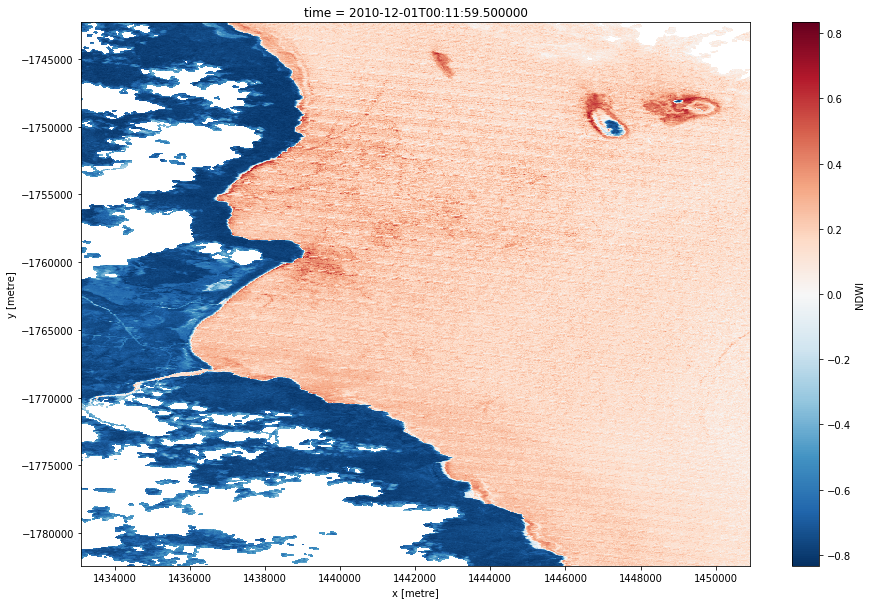

In [3]:
# Load in only clear Landsat observations with < 1% unclear values
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1', 'swir2'], 
                                       masked_prop=0.0, mask_pixel_quality=True) 

data['NDWI'] = BandIndices.calculate_indices(data, 'NDWI')
data['MNDWI'] = BandIndices.calculate_indices(data, 'MNDWI')
data['WI'] = BandIndices.calculate_indices(data, 'WI')
data['AWEI_noshadow'] = BandIndices.calculate_indices(data, 'AWEI_noshadow')
data['AWEI_shadow'] = BandIndices.calculate_indices(data, 'AWEI_shadow')
data.NDWI.isel(time = 2).plot(size=10)
                                                        

## Test ITEM confidence for WA vs OTPS

In [ ]:
lat, lon = -14.9109, 128.3326

# Calculate old tide heights
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()
observed_timepoints = [otps.TimePoint(lon, lat, dt) for dt in observed_datetimes]
observed_predictedtides = otps.predict_tide(observed_timepoints)
tideheights_old = [predictedtide.tide_m for predictedtide in observed_predictedtides]
data['tideheights_old'] = xr.DataArray(tideheights_old, [('time', data.time)])

# Calculate new tide heights
# tideheights_new = sealevel_ds.sel(time=observed_datetimes, method='nearest').sealevel.values.tolist()
tideheights_new = sealevel_ds.interp(time=observed_datetimes).sealevel.values.tolist()
data['tideheights_new'] = xr.DataArray(tideheights_new, [('time', data.time)])


In [ ]:
water_perc = (data.MNDWI > 0).sum(dim=['x', 'y']) * 100 / (len(data.x) * len(data.y))
cor = np.corrcoef(x=data.tideheights_old.values, y=water_perc)[1,0].round(3)
plt.scatter(x=data.tideheights_old.values, y=water_perc.values)
plt.title(f'Old tide heights\nPearson correlation: {cor}');

In [ ]:
water_perc = (data.MNDWI > 0).sum(dim=['x', 'y']) * 100 / (len(data.x) * len(data.y))
cor = np.corrcoef(x=data.tideheights_new.values, y=water_perc)[1,0].round(3)
plt.scatter(x=data.tideheights_new.values, y=water_perc.values)
plt.title(f'New tide heights\nPearson correlation: {cor}');


In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['NDWI'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['NDWI'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['MNDWI'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['MNDWI'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['AWEI_shadow'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['AWEI_shadow'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['AWEI_noshadow'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['AWEI_noshadow'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['WI'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['WI'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
high_old = data.tideheights_old < data.tideheights_new.quantile(0.1)
high_new = data.tideheights_new < data.tideheights_new.quantile(0.1)

In [ ]:
data.sel(time=high_old).median(dim='time')[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, size=5, aspect=1)

In [ ]:
data.sel(time=high_new).median(dim='time')[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, size=5, aspect=1)

In [ ]:
# import numpy as np
intervals = list(zip(np.linspace(data['tideheights_old'].min(), data['tideheights_old'].max(), 11),
                     np.linspace(data['tideheights_new'].min(), data['tideheights_new'].max(), 11)))

out = []
out_ndwi = []

for i, (min_tide_old, min_tide_new) in enumerate(intervals):    
 
    try:
        
        max_tide_old, max_tide_new = intervals[i+1]
        old_subset = data.where((data.tideheights_old >= min_tide_old) & (data.tideheights_old <= max_tide_old), drop = True)
        new_subset = data.where((data.tideheights_new >= min_tide_new) & (data.tideheights_new <= max_tide_new), drop = True)
        print(len(old_subset.time), len(new_subset.time))

        model_comparison = xr.concat([old_subset.NDWI.std(dim = 'time'),
                                      new_subset.NDWI.std(dim = 'time')], 
                                      dim=xr.DataArray(['old', 'new'], dims='model', name='model'))  
        model_comparison.plot(col='model', size=6, aspect=1, vmin=0, vmax=0.5)
        out.append(model_comparison)

        model_comparison = xr.concat([old_subset.NDWI.median(dim = 'time'),
                                      new_subset.NDWI.median(dim = 'time')], 
                                      dim=xr.DataArray(['old', 'new'], dims='model', name='model'))              
        out_ndwi.append(model_comparison)
            
    except:
        print('Skip')
   


In [ ]:
xr.concat(out).mean(dim='concat_dims').plot(col='model', size=6, aspect=2, cmap='RdYlBu_r')

In [ ]:
xr.concat(out).mean(dim='concat_dims').diff(dim='model').plot(size=6, aspect=2.3, robust=True)

## Rolling NIDEM

In [ ]:
data_tidal = data.swap_dims({'time': 'tideheights_old'}).sortby('tideheights_old')
data_tidal = data_tidal[['NDWI', 'MNDWI', 'WI', 'AWEI_noshadow', 'AWEI_shadow', 'red', 'green', 'blue']]
data_tidal['tideheights_var'] = data_tidal.tideheights_old
data_tidal

# data_tidal = data_tidal.rolling(tideheights_old = 30, center=True, min_periods=1).median(dim='tideheights_old')
# data_tidal


In [ ]:
from datacube.helpers import write_geotiff
from skimage.filters import threshold_otsu




test = dict(NDWI=data_tidal.isel(tideheights_old=0)['NDWI'],
            MNDWI=data_tidal.isel(tideheights_old=0)['MNDWI'],
            AWEI_shadow=data_tidal.isel(tideheights_old=0)['AWEI_shadow'],
#             rgb=data_tidal.isel(tideheights_old=0)[['red','green', 'blue']],
#             ternary=data_tidal.isel(tideheights_old=0)[['NDWI', 'MNDWI', 'AWEI_shadow']],
           )


for key, to_write in test.items():
    otsu = threshold_otsu(to_write.values[np.isfinite((to_write > 0).values)])
    print(key, otsu)
    to_write = to_write.to_dataset()
    to_write.attrs['affine'] = data.affine
    to_write.attrs['crs'] = data.crs
    write_geotiff(f'test_{key}.tif', to_write)
    write_geotiff(f'test_{key}_classified.tif', (to_write > 0).astype(np.int32))
    write_geotiff(f'test_{key}_otsu.tif', (to_write > otsu).astype(np.int32))
    

In [ ]:
custom_attrs = {'elev_m': data_tidal['tideheights_var'].values}
custom_attrs_dtypes = {'elev_m': 'float:9.2'}

SpatialTools.contour_extract(z_values=0.25,
                             ds_array=data_tidal.ndwi,
                             ds_crs=data.geobox.crs,
                             ds_affine=data.geobox.affine,
                             output_shp='nidem_test_otsu.shp',
                             dim='tideheights_old',
                             attribute_data=custom_attrs,
                             attribute_dtypes=custom_attrs_dtypes,
                             verbose=False)

In [ ]:
mndwi = (data.green - data.swir1) / (data.green + data.swir1)
# mndwi = (data.green - data.nir) / (data.green + data.nir)

In [ ]:
# mndwi.plot(bins=50)

# from skimage.filters import threshold_otsu


# threshold_otsu(mndwi.values[np.isfinite(mndwi.values)])


def rgb(ds, bands=['red', 'green', 'blue'], index=None, index_dim='time', 
        robust=True, percentile_stretch = None, col_wrap=4, size=6,
        savefig_path=None, savefig_kwargs={}, **kwargs):
    
    """
    Takes an xarray dataset and plots RGB images using three imagery bands (e.g true colour ['red', 'green', 'blue']
    or false colour ['swir1', 'nir', 'green']). The `index` parameter allows easily selecting individual or multiple
    images for RGB plotting. Images can be saved to file by specifying an output path using `image_path`.
    
    This function was designed to be an easy-to-use wrapper around xarray's complex `.plot.imshow()` functionality.

    Last modified: November 2018
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    ds : xarray Dataset
        A two-dimensional or multi-dimensional array to plot as an RGB image. If the array has more than two 
        dimensions (e.g. multiple observations along a 'time' dimension), either use `index` to select one (`index=0`) 
        or multiple observations (`index=[0, 1]`), or create a custom faceted plot using e.g. `col="time", col_wrap=4`.       
    bands : list of strings, optional
        A list of three strings giving the band names to plot. Defaults to '['red', 'green', 'blue']'.
    index : integer or list of integers, optional
        For convenience `index` can be used to select one (`index=0`) or multiple observations (`index=[0, 1]`) from
        the input dataset for plotting. If multiple images are requested these will be plotted as a faceted plot.
    index_dim : string, optional
        The dimension along which observations should be plotted if multiple observations are requested using `index`.
        Defaults to `time`.
    robust : bool, optional
        Produces an enhanced image where the colormap range is computed with 2nd and 98th percentiles instead of the 
        extreme values. Defaults to True.
    percentile_stretch : tuple of floats
        An tuple of two floats (between 0.00 and 1.00) that can be used to clip the colormap range to manually specified 
        percentiles to get more control over the brightness and contrast of the image. The default is None; '(0.02, 0.98)' 
        is equivelent to `robust=True`. If this parameter is used, `robust` will have no effect.
    col_wrap : integer, optional
        The maximum number of columns allowed in faceted plots. Defaults to 4.
    size : integer, optional
        The height (in inches) of each plot. Defaults to 6.
    savefig_path : string, optional
        Path to export image file for the RGB plot. Defaults to None, which does not export an image file.
    savefig_kwargs : dict, optional
        A dict of keyword arguments to pass to `matplotlib.pyplot.savefig` when exporting an image file. For options, 
        see: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html        
    **kwargs : optional
        Additional keyword arguments to pass to `xarray.plot.imshow()`. For more options, see:
        http://xarray.pydata.org/en/stable/generated/xarray.plot.imshow.html  

    Returns
    -------
    An RGB plot of one or multiple observations, and optionally an image file written to file.
    """    
  
    # If value is supplied for `index` (the default), plot using default values and any arguments passed via `**kwargs`.
    if index is None:
        
        if len(ds.dims) > 2 and 'col' not in kwargs:
            raise Exception(f'The input dataset `ds` has more than two dimensions: {list(ds.dims.keys())}. ' 
                             'Please select a single observation using e.g. `index=0`, or enable faceted '
                             'plotting by adding the arguments e.g. `col="time", col_wrap=4` to the function call')

        # Select bands and convert to DataArray
        da = ds[bands].to_array()
        
        # If percentile_stretch is provided, clip plotting to percentile vmin, vmax
        if percentile_stretch:
            vmin, vmax = da.quantile(percentile_stretch).values
            kwargs.update({'vmin': vmin, 'vmax': vmax})
            
        img = da.plot.imshow(robust=robust, col_wrap=col_wrap, size=size, **kwargs)        
 
    # If values provided for `index`, extract corresponding observations and plot as either a single image or facet plot
    else:
        
        # If a float is supplied instead of an integer index, raise exception
        if isinstance(index, float):
            raise Exception(f'Please supply `index` as either an integer or a list of integers')
        
        # If col argument is supplied as well as `index`, raise exception
        if 'col' in kwargs:
            raise Exception(f'Cannot supply both `index` and `col`; please remove one and try again')
            
        # Convert index to generic type list so that number of indices supplied can be computed
        index = index if isinstance(index, list) else [index]
        
        # Select bands and convert to DataArray
        da = ds[bands].isel(**{index_dim: index}).to_array()
        
        # If percentile_stretch is provided, clip plotting to percentile vmin, vmax
        if percentile_stretch:
            vmin, vmax = da.quantile(percentile_stretch).values
            kwargs.update({'vmin': vmin, 'vmax': vmax})
            
        # If multiple index values are supplied, plot as a faceted plot 
        if len(index) > 1:
            
            img = da.plot.imshow(robust=robust, col=index_dim, col_wrap=col_wrap, size=size, **kwargs)
        
        # If only one index is supplied, squeeze out index_dim and plot as a single panel
        else:

            img = da.squeeze(dim=index_dim).plot.imshow(robust=robust, size=size, **kwargs)
    
    # If an export path is provided, save image to file. Individual and faceted plots have a different API (figure
    # vs fig) so we get around this using a try statement:
    if savefig_path: 
        
        print(f'Exporting image to {savefig_path}')
        
        try:
            img.fig.savefig(savefig_path, **savefig_kwargs)
        except:
            img.figure.savefig(savefig_path, **savefig_kwargs)


# rgb(ds=data.isel(time=[1, 5]), savefig_path='test.png', percentile_stretch=(0, 0.8), col="time", col_wrap=4)


In [ ]:
%load_ext autoreload
%autoreload 2

# Import modules
import sys
import datacube

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Contour extraction')
    
# Define a Landsat query
landsat_query = {'lat': (-35.25, -35.35),
                 'lon': (149.05, 149.17),
                 'time': ('2016-02-15', '2016-03-01'),
                 'output_crs': 'EPSG:3577',
                 'resolution': (-25, 25)}

# Import sample Landsat data
landsat_data = dc.load(product='ls8_nbart_albers', 
                       group_by='solar_day',
                       **landsat_query)
    
# # Plot a single observation (option 1)
# DEAPlotting.rgb(ds=landsat_data.isel(time=0))

# # Plot a single observation (option 1)
# DEAPlotting.rgb(ds=landsat_data, index=0)

# # Plot multiple observations as a facet plot (option 1)
# DEAPlotting.rgb(ds=landsat_data, col='time')

# # Plot multiple observations as a facet plot (option 2)
# DEAPlotting.rgb(ds=landsat_data, index=[0, 1])

# # Increase contrast using `percentile_stretch`
# DEAPlotting.rgb(ds=landsat_data, index=[0, 1], 
#                 percentile_stretch=(0.02, 0.9))

# # Pass in any keyword argument to `xarray.plot.imshow()`, e.g. `aspect`. For more 
# # options, see: http://xarray.pydata.org/en/stable/generated/xarray.plot.imshow.html  
# DEAPlotting.rgb(ds=landsat_data, index=[0, 1], 
#                 percentile_stretch=(0.02, 0.9), aspect=1.2)

# Export the RGB image to file using `savefig_path`
DEAPlotting.rgb(ds=landsat_data, index=[0, 1], 
                percentile_stretch=(0.02, 0.9), aspect=1.2, 
                savefig_path='output_image_test.png')



In [ ]:
# rgb(ds=data, col='time', col_wrap=3)

## Download UWA extreme sea levels data

In [ ]:
import pandas as pd
tide_points_pd = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Advanced_coastal/raw_data/AUSTRALIA_2km_SCHISM_points.csv')
tide_points_pd.head()


In [ ]:
tide_points_sel = tide_points_pd.iloc[20000:28400]
tide_points_sel.head()

In [ ]:
# imported the requests library 
import requests
import os

for i in tide_points_sel.ID:      
  
    image_url = f'http://sealevelx.ems.uwa.edu.au/data/{i}_Data.nc'
    out_path = f'output_data/uwa_extremesealevels/{i}_Data.nc'
    
    if i%100 == 0:
        print(image_url)
    
    if not os.path.exists(out_path):

        # URL of the image to be downloaded is defined as image_url 
        r = requests.get(image_url) # create HTTP response object 

        # send a HTTP request to the server and save 
        # the HTTP response in a response object called r 
        if r.status_code == 200:

            with open(f"output_data/uwa_extremesealevels/{i:05d}_Data.nc",'wb') as f: 

                # write the contents of the response (r.content) 
                # to a new file in binary mode. 
                f.write(r.content) 


## Load WA sea level into xarray format

In [4]:
import pandas as pd
import os
tide_points_pd = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Advanced_coastal/raw_data/AUSTRALIA_2km_SCHISM_points.csv')

y_max, y_min = query['y']
x_min, x_max = query['x']

tide_points_sel = tide_points_pd.loc[(tide_points_pd.X > x_min) & 
                                     (tide_points_pd.X < x_max) &
                                     (tide_points_pd.Y > y_min) &
                                     (tide_points_pd.Y < y_max)].copy()

tide_points_sel['path'] = tide_points_sel.apply(lambda x: 'output_data/uwa_extremesealevels/{0:05d}_Data.nc'.format(int(x.ID)), axis=1)
files = tide_points_sel['path'].to_list()
files = [file for file in files if os.path.exists(file)]
len(files)

26

In [ ]:
import pandas as pd
tide_points_pd = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Advanced_coastal/raw_data/AUSTRALIA_2km_SCHISM_points.csv')

y_max, x_min = -11.110152, 130.832455
y_min, x_max = -12.358548, 132.238351

tide_points_sel = tide_points_pd.loc[(tide_points_pd.X > x_min) & 
                                     (tide_points_pd.X < x_max) &
                                     (tide_points_pd.Y > y_min) &
                                     (tide_points_pd.Y < y_max)].copy()

tide_points_sel['path'] = tide_points_sel.apply(lambda x: 'output_data/uwa_extremesealevels/{0:05d}_Data.nc'.format(int(x.ID)), axis=1)
files = tide_points_sel['path'].to_list()
files = [file for file in files if os.path.exists(file)]
len(files)

In [7]:
# Open all data
all_nodes = xr.open_mfdataset(paths=files, concat_dim='file').squeeze('coast_id')

# Interpolate hourly results to get sea level estimates for exact acquisition time
all_nodes = all_nodes.interp(time=data.time.data.astype('M8[s]').astype('O').tolist())

# Select only required timesteps
all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

# Re-index to give latitude, longitude and time dimensions
test = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()

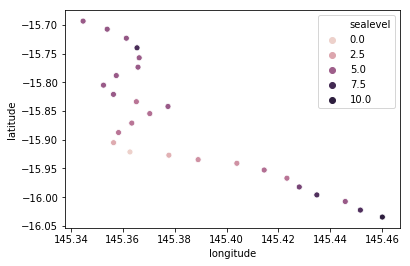

In [77]:
test_df_subset = test.isel(time=0).sealevel.to_dataframe().dropna(axis=0).reset_index() 
test_df_subset

import seaborn as sns
sns.scatterplot(data =test_df_subset,  x='longitude', y='latitude', hue='sealevel')

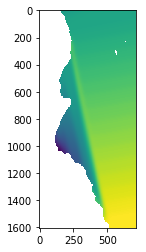

In [78]:
def interp_tides(x_vals, y_vals, z_vals, transform, out_shape, fill_nearest=None, gaussian=None):

    # Create grid to interpolate into
    x_size, _, upleft_x, _, y_size, upleft_y = transform[0:6]
    bottomright_y, bottomright_x = rasterio.transform.array_bounds(out_shape[0], 
                                                                   out_shape[1], 
                                                                   transform)[1:3]
    xi = np.linspace(upleft_x, bottomright_x, out_shape[1])
    yi = np.linspace(upleft_y, bottomright_y, out_shape[0])
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate
    out = scipy.interpolate.griddata((x_vals, y_vals), z_vals, (xi, yi), method='linear')
    
    # Calculate nearest
    if fill_nearest:
        
        nearest_inds = nd.distance_transform_edt(input=np.isnan(out), 
                                                 return_distances=False, 
                                                 return_indices=True)
        out = out[tuple(nearest_inds)]
        
    # Apply guassian filter
    if gaussian and fill_nearest:

        out = nd.filters.gaussian_filter(out, sigma=gaussian)
        
    return out[:,:,0]


import rasterio
from pyproj import Proj, transform
x_proj, y_proj = transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), 
                           test_df_subset.longitude.values,                                                                    
                           test_df_subset.latitude.values)


out = interp_tides(x_vals=x_proj, 
                   y_vals=y_proj, 
                   z_vals=test_df_subset[['sealevel']].values, 
                   transform=data.geobox.transform, 
                   out_shape=data.NDWI.shape[1:], 
                   fill_nearest=True,
                   gaussian=15)


# Get shoreline mask
coastline_gpd = gpd.read_file('/g/data/u46/users/adh547/shapefiles/australia/australia/cstauscd_r.shp')
coastline_gpd = coastline_gpd.loc[coastline_gpd.FEAT_CODE != 'sea']
coastline_gpd = coastline_gpd.to_crs(epsg=3577)
coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
                                                 out_shape=data.NDWI.shape[1:],
                                                 transform=data.geobox.transform,
                                                 all_touched=False, invert=True)

# Remove land
out[coastline_mask] = np.nan
plt.imshow(out)